In [1]:

from dingo import MetabolicNetwork
import numpy as np

import sys
sys.path.insert(0, '../scripts/')
from load_modify_sample_utils import load_model, get_objective_functions, get_reaction_bounds, modify_model, sample_gapsplit, plot_grid_95_reactions
from load_modify_sample_utils import sample_dingo, sample_optgp, sampling_statistics, export_to_pickle
from graphs_utils import construct_graph, plot_graph
from distributions_comparison_utils import significantly_altered_reactions
from loopless_utils import get_loopless_solutions_from_samples, calculate_affected_samples, set_bounds_from_loopless_solution_samples
from loopless_utils import calculate_distances_from_samples, calculate_distances_from_reactions, violin_plot_samples_distances


/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/touliopoulos/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:

# https://doi.org/10.1093/bioinformatics/btaa813
# Renz2020 - GEM of Human alveolar macrophage with SARS-CoV-2

(cobra_model,
cobra_model_reactions,
dingo_model,
dingo_model_reactions) = load_model("../private_data/Reconstructions_data/iAB_AMO1410_SARS-CoV-2_V1.xml")



# https://doi.org/10.26508/lsa.202000954
# Bannerman2020 - Integrated model of the human airway epithelial cell and the SARS-CoV-2 virus

#(cobra_model,
#cobra_model_reactions,
#dingo_model,
#dingo_model_reactions) = load_model("../private_data/Reconstructions_data/iHsaEC21.xml")



objective_functions = get_objective_functions(cobra_model)
print(objective_functions)

default_reaction_bounds = get_reaction_bounds(cobra_model)



cobra_model_objective_VBOF_opt_0_minimize, dingo_model_objective_VBOF_opt_0_minimize = modify_model(cobra_model, 
                                                            objective_function="VBOF", 
                                                            optimal_percentage=0,
                                                            objective_direction="min")

objective_functions = get_objective_functions(cobra_model_objective_VBOF_opt_0_minimize)
print(objective_functions)



cobra_model_objective_VBOF_opt_0_maximize, dingo_model_objective_VBOF_opt_0_maximize = modify_model(cobra_model, 
                                                            objective_function="VBOF", 
                                                            optimal_percentage=0,
                                                            objective_direction="max")

objective_functions = get_objective_functions(cobra_model_objective_VBOF_opt_0_maximize)
print(objective_functions)



cobra_model_objective_VBOF_opt_100_maximize, dingo_model_objective_VBOF_opt_100_maximize = modify_model(cobra_model, 
                                                                objective_function="VBOF",
                                                                optimal_percentage=100,
                                                                objective_direction="max")

objective_functions = get_objective_functions(cobra_model_objective_VBOF_opt_100_maximize)
print(objective_functions)



Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
['VBOF']
Read LP format model from file /tmp/tmpu853umny.lp
Reading time = 0.02 seconds
: 2572 rows, 6788 columns, 25528 nonzeros
['VBOF']
Read LP format model from file /tmp/tmpu_pbf59o.lp
Reading time = 0.04 seconds
: 2572 rows, 6788 columns, 25528 nonzeros
['VBOF']
Read LP format model from file /tmp/tmptrc9x6pm.lp
Reading time = 0.02 seconds
: 2572 rows, 6788 columns, 25528 nonzeros
['VBOF']


In [ ]:


from cobra.flux_analysis import flux_variability_analysis
import pandas as pd


def loops_enumeration_from_fva(ec_cobra_model):
    
    fva_noloop = flux_variability_analysis(ec_cobra_model, loopless=False)

    # Perform FVA with loopless constraints
    fva_loopless = flux_variability_analysis(ec_cobra_model, loopless=True)

    # Calculate span = max - min for each
    fva_noloop['span_noloop'] = fva_noloop['maximum'] - fva_noloop['minimum']
    fva_loopless['span_loopless'] = fva_loopless['maximum'] - fva_loopless['minimum']

    # Combine the results into a single DataFrame
    fva_comparison = pd.DataFrame({
        'span_noloop': fva_noloop['span_noloop'],
        'span_loopless': fva_loopless['span_loopless']
    })

    # Calculate the difference in spans (optional)
    fva_comparison['span_difference'] = fva_comparison['span_noloop'] - fva_comparison['span_loopless']
    
    significant_diff = fva_comparison[fva_comparison['span_difference'] > 1e-6]
    
    return significant_diff



significant_diff = loops_enumeration_from_fva(cobra_model)
print(significant_diff)

                         span_noloop  span_loopless  span_difference
DM_atp_LPAREN_c_RPAREN_     1.310342       0.000000         1.310342
10FTHF5GLUtl                0.327585       0.087272         0.240313
10FTHF5GLUtm                0.327585       0.087104         0.240482
10FTHF6GLUtl                0.262068       0.000000         0.262068
10FTHF6GLUtm                0.262068       0.000000         0.262068
...                              ...            ...              ...
VITD3tm                  1000.000000       0.000000      1000.000000
VITD3tm3                 1000.000000       0.000000      1000.000000
XYLK                        0.433076       0.178513         0.254564
XYLTD_Dr                    0.433076       0.178513         0.254564
XYLUR                       0.433076       0.260414         0.172663

[1210 rows x 3 columns]


In [15]:

significant_diff_2 = significant_diff[significant_diff['span_difference'] > 10]
print(significant_diff_2)



                    span_noloop  span_loopless  span_difference
25HVITD2t           1000.000000           0.00      1000.000000
25HVITD2tin         1000.000000           0.00      1000.000000
25HVITD2tin_DASH_m  1000.000000           0.00      1000.000000
25HVITD2tm          1000.000000           0.00      1000.000000
25HVITD3t           1000.000000           0.00      1000.000000
...                         ...            ...              ...
VALtec              1000.002921           0.01       999.992921
VITD3t              1000.000000           0.00      1000.000000
VITD3t2             1000.000000           0.00      1000.000000
VITD3tm             1000.000000           0.00      1000.000000
VITD3tm3            1000.000000           0.00      1000.000000

[457 rows x 3 columns]


In [ ]:

cobra_model_objective_GK1_opt_0_minimize, _ = modify_model(cobra_model, 
                                                            objective_function="GK1", 
                                                            optimal_percentage=0,
                                                            objective_direction="min")

objective_functions = get_objective_functions(cobra_model_objective_GK1_opt_0_minimize)
print(objective_functions)



Read LP format model from file /tmp/tmpmtson4j7.lp
Reading time = 0.03 seconds
: 2572 rows, 6788 columns, 25528 nonzeros
['GK1']


In [ ]:

samples_optgp_minimize_GK1_opt_0_rep_1 = sample_optgp(cobra_model_objective_GK1_opt_0_minimize, n_samples = 10000, thinning = 1000, reaction_in_rows = True)
#samples_optgp_minimize_GK1_opt_0_rep_2 = sample_optgp(cobra_model_objective_GK1_opt_0_minimize, n_samples = 10000, thinning = 1000, reaction_in_rows = True)



Read LP format model from file /tmp/tmpy1en_z3k.lp
Reading time = 0.03 seconds
: 2572 rows, 6788 columns, 25528 nonzeros


In [ ]:

print(len(dingo_model_reactions))
print(dingo_model_reactions[-2])
print(dingo_model_reactions[-1])



3394
SK_Tyr_DASH_ggn
BIOMASS_mac
VBOF
EX_ala_DASH_L_LPAREN_e_RPAREN_
SK_Tyr_DASH_ggn: Tyr_DASH_ggn_c <=> 
max
min


In [3]:

samples_optgp_minimize_VBOF_opt_0_rep_1 = sample_optgp(cobra_model_objective_VBOF_opt_0_minimize, n_samples = 10000, thinning = 1000, reaction_in_rows = True)
samples_optgp_minimize_VBOF_opt_0_rep_2 = sample_optgp(cobra_model_objective_VBOF_opt_0_minimize, n_samples = 10000, thinning = 1000, reaction_in_rows = True)



samples_optgp_maximize_VBOF_opt_0_rep_1 = sample_optgp(cobra_model_objective_VBOF_opt_0_maximize, n_samples = 10000, thinning = 1000, reaction_in_rows = True)
samples_optgp_maximize_VBOF_opt_0_rep_2 = sample_optgp(cobra_model_objective_VBOF_opt_0_maximize, n_samples = 10000, thinning = 1000, reaction_in_rows = True)



samples_optgp_maximize_VBOF_opt_100_rep_1 = sample_optgp(cobra_model_objective_VBOF_opt_100_maximize, n_samples = 10000, thinning = 1000, reaction_in_rows = True)
samples_optgp_maximize_VBOF_opt_100_rep_2 = sample_optgp(cobra_model_objective_VBOF_opt_100_maximize, n_samples = 10000, thinning = 1000, reaction_in_rows = True)



Read LP format model from file /tmp/tmpvfmqio27.lp
Reading time = 0.07 seconds
: 2572 rows, 6788 columns, 25528 nonzeros
Read LP format model from file /tmp/tmpr3vc26l1.lp
Reading time = 0.03 seconds
: 2572 rows, 6788 columns, 25528 nonzeros
Read LP format model from file /tmp/tmpfmlulcg3.lp
Reading time = 0.02 seconds
: 2572 rows, 6788 columns, 25528 nonzeros
Read LP format model from file /tmp/tmpylxn3lxp.lp
Reading time = 0.03 seconds
: 2572 rows, 6788 columns, 25528 nonzeros
Read LP format model from file /tmp/tmp8xxm5zmy.lp
Reading time = 0.02 seconds
: 2572 rows, 6788 columns, 25528 nonzeros
Read LP format model from file /tmp/tmp2_cmz7wn.lp
Reading time = 0.03 seconds
: 2572 rows, 6788 columns, 25528 nonzeros


In [ ]:

from load_modify_sample_utils import export_to_pickle 

export_to_pickle(samples = samples_optgp_minimize_GK1_opt_0_rep_1, 
                 filename= "../private_data/Sampling_data/Virus/iAB-AMO1410-SARS-CoV-2_V1_Samples_10K_Thinning_1000_GK1_0_Direction_Min_Rep_1")

#export_to_pickle(samples = samples_optgp_loopless_solutions, filename= "../private_data/Sampling_data/Virus_Samples_10K_Thinning_100_VBOF_0_loopless_solutions")



In [ ]:


from load_modify_sample_utils import load_from_pickle

samples_optgp_maximize_VBOF_opt_100_rep_1 = samples_optgp_cycles_model = load_from_pickle("../private_data/Sampling_data/Virus/iAB-AMO1410-SARS-CoV-2_V1_Samples_10K_Thinning_1000_VBOF_100_Direction_Max_Rep_1")
samples_optgp_maximize_VBOF_opt_100_rep_2 = samples_optgp_cycles_model = load_from_pickle("../private_data/Sampling_data/Virus/iAB-AMO1410-SARS-CoV-2_V1_Samples_10K_Thinning_1000_VBOF_100_Direction_Max_Rep_2")


samples_optgp_maximize_VBOF_opt_0_rep_1 = samples_optgp_cycles_model = load_from_pickle("../private_data/Sampling_data/Virus/iAB-AMO1410-SARS-CoV-2_V1_Samples_10K_Thinning_1000_VBOF_0_Direction_Max_Rep_1")
samples_optgp_maximize_VBOF_opt_0_rep_2 = samples_optgp_cycles_model = load_from_pickle("../private_data/Sampling_data/Virus/iAB-AMO1410-SARS-CoV-2_V1_Samples_10K_Thinning_1000_VBOF_0_Direction_Max_Rep_2")


samples_optgp_minimize_VBOF_opt_0_rep_1 = samples_optgp_cycles_model = load_from_pickle("../private_data/Sampling_data/Virus/iAB-AMO1410-SARS-CoV-2_V1_Samples_10K_Thinning_1000_VBOF_0_Direction_Min_Rep_1")
samples_optgp_minimize_VBOF_opt_0_rep_2 = samples_optgp_cycles_model = load_from_pickle("../private_data/Sampling_data/Virus/iAB-AMO1410-SARS-CoV-2_V1_Samples_10K_Thinning_1000_VBOF_0_Direction_Min_Rep_2")

#samples_optgp_cycles_model_loopless_solutions = load_from_pickle("../private_data/Sampling_data/Virus_Samples_10K_Thinning_100_VBOF_0_loopless_solutions")


### Check for fluxes consistency

In [10]:

conditions=[samples_optgp_minimize_VBOF_opt_0_rep_1, samples_optgp_minimize_VBOF_opt_0_rep_2]
selected_comparisons = [(0, 1)]

_, significant_diff_reactions, not_significant_diff_reactions = significantly_altered_reactions(conditions, 
                                                                                                selected_comparisons, 
                                                                                                cobra_model=cobra_model,
                                                                                                p_value_cutoff = 0.05,
                                                                                                fold_change_cutoff=2)

print(significant_diff_reactions)
print(len(significant_diff_reactions))



conditions=[samples_optgp_maximize_VBOF_opt_0_rep_1, samples_optgp_maximize_VBOF_opt_0_rep_2]
selected_comparisons = [(0, 1)]

_, significant_diff_reactions, not_significant_diff_reactions = significantly_altered_reactions(conditions, 
                                                                                                selected_comparisons, 
                                                                                                cobra_model=cobra_model,
                                                                                                p_value_cutoff = 0.05,
                                                                                                fold_change_cutoff=2.0)

print(significant_diff_reactions)
print(len(significant_diff_reactions))



conditions=[samples_optgp_maximize_VBOF_opt_100_rep_1, samples_optgp_maximize_VBOF_opt_100_rep_2]
selected_comparisons = [(0, 1)]

_, significant_diff_reactions, not_significant_diff_reactions = significantly_altered_reactions(conditions, 
                                                                                                selected_comparisons, 
                                                                                                cobra_model=cobra_model,
                                                                                                p_value_cutoff = 0.05,
                                                                                                fold_change_cutoff=2.0)

print(significant_diff_reactions)
print(len(significant_diff_reactions))



['ALAtN1', 'ASNtN1', 'CITRtm', 'CYTK13n', 'CYTK4', 'CYTK7n', 'FATP8t', 'FUMSO3tm', 'FUMSO4tm', 'GALT', 'GALU', 'GALt4_2', 'LGNCt', 'MALSO3tm', 'MALSO4tm', 'MECOALm', 'MECOAS1m', 'NDPK1n', 'ORNt3m', 'ORNt4m', 'UGLT', 'UMPK2', 'UMPK4n']
23
['EX_pyr_LPAREN_e_RPAREN_', 'ADK1', 'ADK1m', 'ADK3', 'ADK3m', 'ALAtN1', 'CITRtm', 'CYSGLUexR', 'CYTK13n', 'CYTK8', 'FUM', 'FUMm', 'GALT', 'GALU', 'H2Otm', 'INSTt4', 'It', 'NAHCO3_HCLt', 'NAt5', 'NCKt', 'NDPK2n', 'NDPK3', 'ORNt3m', 'ORNt4m', 'PROt2r', 'PYRt2r', 'THRGLNexR', 'UGLT', 'UMPK5', 'UMPK7n']
30
['CYTK1', 'CYTK10', 'CYTK13n', 'DTDPtn', 'DTTPtn', 'FATP1t', 'FATP2t', 'FATP8t', 'FUM', 'FUMm', 'H2Otm', 'HDCAtr', 'LGNCt', 'NDPK4', 'NDPK4n', 'OCDCEAtr', 'RAI2', 'RETI2', 'SERGLNexR', 'UMPK2', 'UMPK5']
21


In [11]:


#conditions=[samples_optgp_minimize_VBOF_opt_0_rep_1, samples_optgp_maximize_VBOF_opt_100_rep_1]
conditions=[samples_optgp_maximize_VBOF_opt_0_rep_1, samples_optgp_maximize_VBOF_opt_100_rep_1]

selected_comparisons = [(0, 1)]

_, significant_diff_reactions, not_significant_diff_reactions = significantly_altered_reactions(conditions, 
                                                                                                selected_comparisons, 
                                                                                                cobra_model=cobra_model,
                                                                                                p_value_cutoff = 0.05,
                                                                                                fold_change_cutoff=1.5)


print(significant_diff_reactions)
print(len(significant_diff_reactions))

['EX_ala_DASH_D_LPAREN_e_RPAREN_', 'EX_ala_DASH_L_LPAREN_e_RPAREN_', '3HCO3_NAt', 'ABUTt2r', 'ABUTt4_LPAREN_2_RPAREN_r', 'ALADGLNexR', 'ALADGLYexR', 'ALAGLYexR', 'ALAR', 'ALATHRNaEx', 'ALCD21_L', 'ALCD22_L', 'ALR2', 'ALR3', 'ASCBt', 'ASCBt4', 'ASNCYSNaEx', 'ASNt4', 'CHOLK', 'CITt4_2', 'CITt4_4', 'CYSASNNaEx', 'CYSGLNNaEx', 'CYSGLYexR', 'CYTK10', 'CYTK12n', 'CYTK13', 'CYTK14n', 'CYTK3n', 'CYTK4n', 'CYTK5', 'CYTK5n', 'CYTK6', 'CYTK6n', 'CYTK7', 'CYTK8', 'CYTK9', 'DALAt2r', 'DNDPt14m', 'DNDPt16m', 'DNDPt25m', 'DNDPt26m', 'DNDPt29m', 'DOPAt4_LPAREN_2_RPAREN_r', 'DOPAtu', 'FATP1t', 'FATP8t', 'FRUt1r', 'FRUt4', 'FUMSO3tm', 'FUMSO4tm', 'GLCt2_2', 'GLCt2r', 'GLNSERNaEx', 'GLYt7_LPAREN_311_RPAREN_r', 'HDCAtr', 'HSD11B1r', 'HSD11B2r', 'IDPtn', 'ILEt4', 'ILEtec', 'INSTt2r', 'ITPtn', 'KCC2t', 'L_DASH_LACt2r', 'L_DASH_LACt4r', 'LGNCt', 'MALSO3tm', 'MALSO4tm', 'NAHCO3_HCLt', 'NAIt', 'NAt3_1', 'NDPK1m', 'NDPK2n', 'NDPK3', 'NDPK3n', 'NDPK9', 'NDPK9n', 'PHEt4', 'PHEtec', 'PROSTGE2t', 'PROSTGE2t2', 'PRO

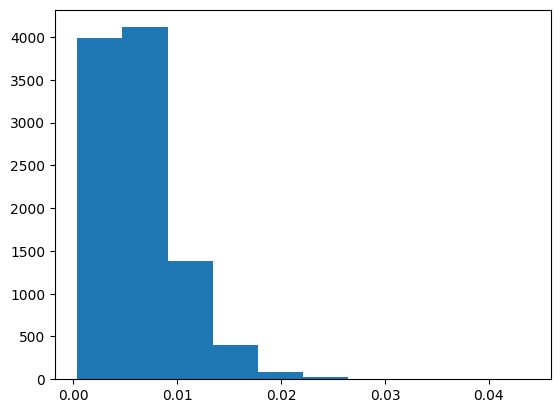

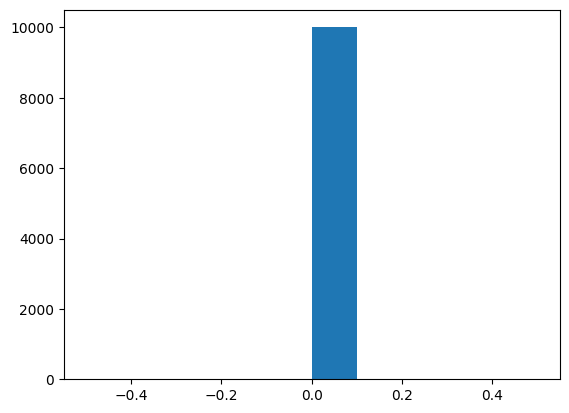

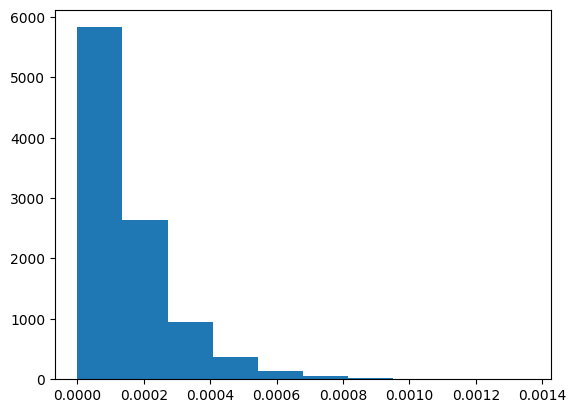

'\nplt.hist(samples_optgp_maximize_VBOF_opt_0_rep_1[index])\nplt.show()\n\n\nplt.hist(samples_optgp_maximize_VBOF_opt_0_rep_1[index])\nplt.show()\n\n\nplt.hist(samples_optgp_maximize_VBOF_opt_100_rep_1[index])\nplt.show()\n'

In [9]:

index1 = dingo_model_reactions.index("GK1")
index2 = dingo_model_reactions.index("VBOF")
index3 = dingo_model_reactions.index("BIOMASS_mac")


import matplotlib.pyplot as plt


plt.hist(samples_optgp_minimize_GK1_opt_0_rep_1[index1])
plt.show()


plt.hist(samples_optgp_minimize_GK1_opt_0_rep_1[index2])
plt.show()


plt.hist(samples_optgp_minimize_GK1_opt_0_rep_1[index3])
plt.show()


"""
plt.hist(samples_optgp_maximize_VBOF_opt_0_rep_1[index])
plt.show()


plt.hist(samples_optgp_maximize_VBOF_opt_0_rep_1[index])
plt.show()


plt.hist(samples_optgp_maximize_VBOF_opt_100_rep_1[index])
plt.show()
"""

In [ ]:

from correlations_utils import correlated_reactions, split_forward_reverse


extended_steady_states_condition_1, extended_reactions_conditions_1 = split_forward_reverse(samples_optgp_minimize_GK1_opt_0_rep_1, reactions=dingo_model_reactions)

(linear_correlation_matrix_1, 
#non_linear_correlation_matrix_1, 
#mixed_correlation_matrix_1, 
correlations_dictionary_1
) = correlated_reactions(
        steady_states = extended_steady_states_condition_1,
        boolean_sharing_metabolites_matrix=None,
        reactions=extended_reactions_conditions_1, 
        linear_corr_cutoff = 0.3, 
        indicator_cutoff = 1.2,
        jensenshannon_cutoff = 0.05,
        std_cutoff= 1e-2,
        include_non_linear = False, 
        cells = 4, 
        cop_coeff = 0.2, 
        lower_triangle = False, 
        verbose = True)



extended_steady_states_condition_2, extended_reactions_conditions_2 = split_forward_reverse(samples_optgp_maximize_VBOF_opt_100_rep_1, reactions=dingo_model_reactions)

(linear_correlation_matrix_2, 
#non_linear_correlation_matrix_2, 
#mixed_correlation_matrix_2, 
correlations_dictionary_2
) = correlated_reactions(
        steady_states = extended_steady_states_condition_2,
        boolean_sharing_metabolites_matrix=None,
        reactions=extended_reactions_conditions_2, 
        linear_corr_cutoff = 0.3, 
        indicator_cutoff = 1.2,
        jensenshannon_cutoff = 0.05,
        std_cutoff= 1e-2,
        include_non_linear = False, 
        cells = 4, 
        cop_coeff = 0.2, 
        lower_triangle = False, 
        verbose = True)




In [68]:


G1, pos1 = construct_graph(linear_correlation_matrix_1, 
                         non_linear_correlation_matrix=None, 
                         reactions=extended_reactions_conditions_1,
                         remove_unconnected_nodes=True,
                         correction=True)

plot_graph(G1, pos1)



G2, pos2= construct_graph(linear_correlation_matrix_2, 
                         non_linear_correlation_matrix=None, 
                         reactions=extended_reactions_conditions_2,
                         remove_unconnected_nodes=True,
                         correction=True)

plot_graph(G2, pos2)



KeyboardInterrupt: 

In [ ]:

from graph_utils import compare_betweenness_centralities


sorted_nodes = compare_betweenness_centralities(G1, G2)
print(sorted_nodes.get("GK1"))